In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Importing the training and testing sets
%run "./Data Splitting.ipynb"

In [3]:
# Retreiving the different types of offers
subscriptions = df["IN_SUBSCRIPTION_TYPE"].unique()
subscriptions

array([-1.,  1.,  2.,  3.,  4.,  6.,  7.,  8.,  5.,  9.])

In [4]:
# Grouping the offers with the ones that generate approximately the same revenue
empty_subscription = np.array([-1])
subscriptions_1_2 = np.array([1,2])
subscriptions_3 = np.array([3])
subscriptions_6 = np.array([6])
other_subscriptions = np.array([4,5,7,8,9])

In [6]:
# seperating all the dfs by subscriptions
grouped_df = df.groupby(["IN_SUBSCRIPTION_TYPE","REPORT_DATE"]).agg({
    "REVENUE":"sum",
    "IS_CODE6_ENABLED":"first",
}).reset_index()

empty_subscription_df =  grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(empty_subscription)].drop(columns=["IN_SUBSCRIPTION_TYPE"]).reset_index(drop=True)
subscriptions_1_2_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(subscriptions_1_2)].groupby(["REPORT_DATE"]).agg({
    "REVENUE":"sum",
    "IS_CODE6_ENABLED":"first",
}).reset_index()
subscriptions_3_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(subscriptions_3)].drop(columns=["IN_SUBSCRIPTION_TYPE"]).reset_index(drop=True)
subscriptions_6_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(subscriptions_6)].drop(columns=["IN_SUBSCRIPTION_TYPE"]).reset_index(drop=True)
other_subscriptions_df = grouped_df[grouped_df["IN_SUBSCRIPTION_TYPE"].isin(other_subscriptions)].groupby(["REPORT_DATE"]).agg({
    "REVENUE":"sum",
    "IS_CODE6_ENABLED":"first",
}).reset_index()


In [7]:
empty_subscription_df.shape,subscriptions_1_2_df.shape,subscriptions_3_df.shape,subscriptions_6_df.shape,other_subscriptions_df.shape

((729, 3), (729, 3), (729, 3), (729, 3), (729, 3))

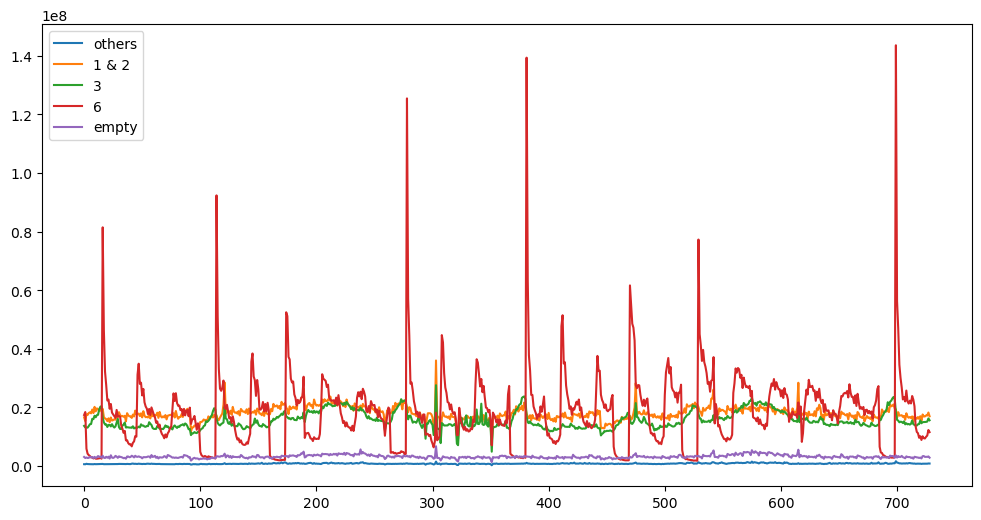

In [8]:
# Plotting the revenues 
plt.figure(figsize=(12, 6))

other_subscriptions_df["REVENUE"].plot(label="others")
subscriptions_1_2_df["REVENUE"].plot(label="1 & 2")
subscriptions_3_df["REVENUE"].plot(label="3")
subscriptions_6_df["REVENUE"].plot(label="6")
empty_subscription_df["REVENUE"].plot(label="empty")

plt.legend()

In [9]:
# Importing the necessary libraries for the training and standarization
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Importing the libraries to save the scalers for later use
import pickle

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback to be able to not train non performant models
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=50,    
    min_delta=0.0001,
    verbose=2,           
    restore_best_weights=True
)

# LSTM of offers : 
<h1 style="color:red;">1 and 2</h1>

In [20]:
# Defining the grouped_df to be used here which is the 1_2 dataframe
grouped_df = subscriptions_1_2_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [22]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_1_2.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [24]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [26]:
# Defining the LSTM model
model_1_2 = Sequential()
model_1_2.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_1_2.add(LSTM(68, return_sequences=True))  
model_1_2.add(Dropout(0.1))   
model_1_2.add(LSTM(68, return_sequences=True)) 
model_1_2.add(Dropout(0.1))  
model_1_2.add(LSTM(36, return_sequences=True)) 
model_1_2.add(Dropout(0.1))  
model_1_2.add(LSTM(16, return_sequences=False)) 
model_1_2.add(Dense(1))
model_1_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1, 68)               │          35,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1, 36)               │          15,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 36)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 16)                  │           3,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,153 (356.07 KB)

 Trainable params: 91,153 (356.07 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Compile the model
model_1_2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Fit the model
history_1_2 = model_1_2.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=4, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.1860 - val_loss: 0.0398
Epoch 2/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0664 - val_loss: 0.0398
Epoch 3/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0561 - val_loss: 0.0356
Epoch 4/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0528 - val_loss: 0.0504
Epoch 5/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0463 - val_loss: 0.0327
Epoch 6/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0519 - val_loss: 0.0303
Epoch 7/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0456 - val_loss: 0.0351
Epoch 8/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0408 - val_loss: 0.0278
Epoch 9/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0452 - val_loss: 0.0345
Epoch 10/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0429 - val_loss: 0.0277
Epoch 11/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0393 - val_loss: 0.0528
Epoch 12/400
140/140 ━━━━━━━━━━━━━━━━━━

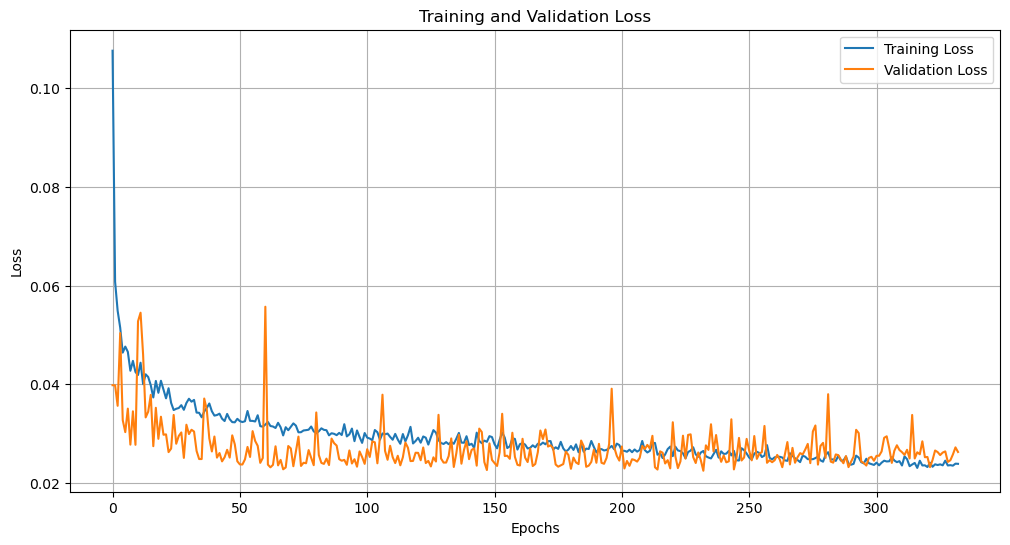

In [29]:
# Checking if there is a overfitting

history_dict = history_1_2.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_1_2.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_1_2 = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_1_2

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step


,test,pred,diff_val_by_million,diff_percentage
0,20413232.0,19712768.0,0.700464,3.431421
1,20513437.0,19005082.0,1.508355,7.353010
2,20025826.0,19328284.0,0.697542,3.483212
3,19861678.0,19762548.0,0.099130,0.499102
4,18612033.0,18728306.0,0.116273,0.624720
...,...,...,...,...
135,16927325.0,16757841.0,0.169484,1.001245
136,17288519.0,17023922.0,0.264597,1.530478
137,17239755.0,16657016.0,0.582739,3.380205
138,18269577.0,17504854.0,0.764723,4.185773


count    140.000000
mean       3.494358
std        4.160168
min        0.006251
25%        1.019637
50%        2.566255
75%        4.748637
max       34.157863
Name: diff_percentage, dtype: float64


<Axes: >

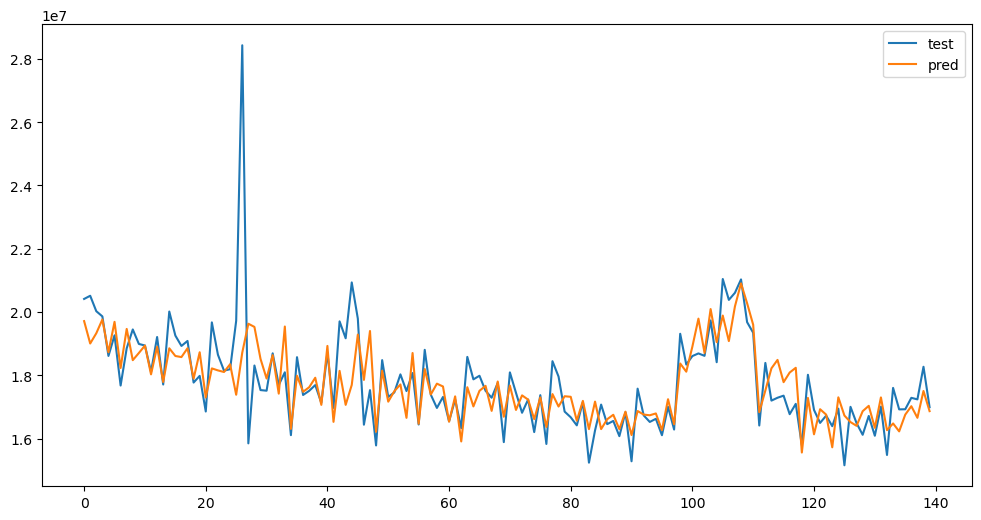

In [31]:
print(data_1_2["diff_percentage"].describe())

data_1_2[["test","pred"]].plot(figsize=(12, 6))

In [36]:
# Saving the model

model_1_2.save('../Saved Models/m_1_2.keras')

# LSTM of offers : 
<h1 style="color:red;">empty</h1>

In [39]:
# Defining the grouped_df to be used here which is the 1_2 dataframe
grouped_df = empty_subscription_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [41]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_empty.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [43]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [45]:
# Defining the LSTM model
model_empty= Sequential()
model_empty.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_empty.add(LSTM(500, return_sequences=True))  
model_empty.add(Dropout(0.1))  
model_empty.add(LSTM(500, return_sequences=True))  
model_empty.add(Dropout(0.1))  
model_empty.add(LSTM(300, return_sequences=True))  
model_empty.add(Dropout(0.1))  
model_empty.add(LSTM(300, return_sequences=True)) 
model_empty.add(Dropout(0.1)) 
model_empty.add(LSTM(300, return_sequences=False)) 
model_empty.add(Dense(1))
model_empty.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 1, 500)              │       1,124,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 1, 500)              │       2,002,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 1, 300)              │         961,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 300)                 │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             301 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,529,901 (21.09 MB)

 Trainable params: 5,529,901 (21.09 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Compile the model
model_empty.compile(optimizer=Adam(learning_rate=0.0002), loss='mean_absolute_error')

# Fit the model
history_empty = model_empty.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=8, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - loss: 0.0755 - val_loss: 0.0628
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - loss: 0.0638 - val_loss: 0.0644
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.0600 - val_loss: 0.0761
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0551 - val_loss: 0.0687
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0590 - val_loss: 0.0768
Restoring model weights from the end of the best epoch: 1.


In [ ]:
# Checking if there is a overfitting

history_dict = history_empty.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_empty.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_empty = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_empty

count    140.000000
mean       5.693757
std        5.429765
min        0.070441
25%        1.953526
50%        4.026328
75%        7.611096
max       39.302172
Name: diff_percentage, dtype: float64


<Axes: >

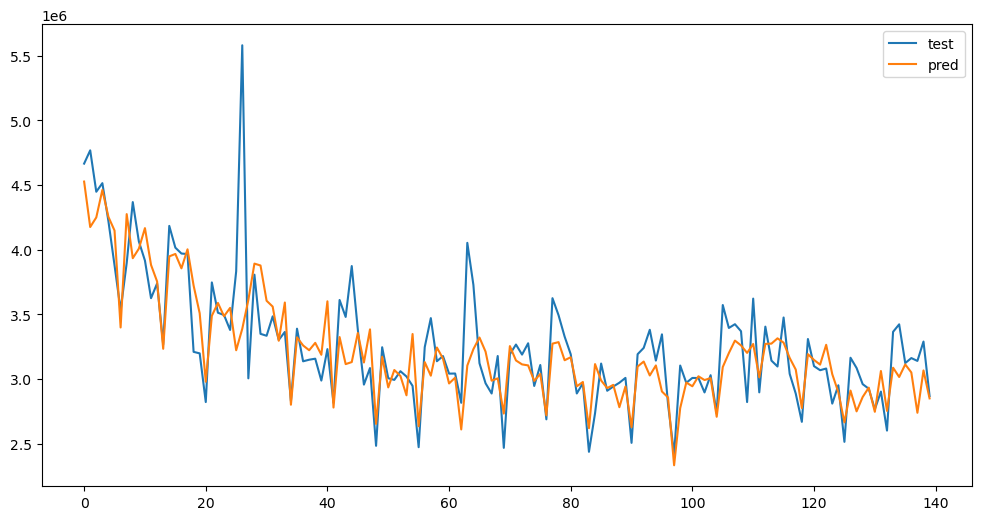

In [60]:
print(data_empty["diff_percentage"].describe())

data_empty[["test","pred"]].plot(figsize=(12, 6))

In [65]:
# Saving the model

model_empty.save('../Saved Models/m_empty.keras')

# LSTM of offers : 
<h1 style="color:red;">others</h1>

In [92]:
# Defining the grouped_df to be used here which is the other_subscritions dataframe
grouped_df = other_subscriptions_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [94]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_others.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [96]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [98]:
# Defining the LSTM model
model_others= Sequential()
model_others.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_others.add(LSTM(500, return_sequences=True))  
model_others.add(Dropout(0.1))  
model_others.add(LSTM(300, return_sequences=True)) 
model_others.add(Dropout(0.1)) 
model_others.add(LSTM(300, return_sequences=True)) 
model_others.add(Dropout(0.1)) 
model_others.add(LSTM(300, return_sequences=True)) 
model_others.add(Dropout(0.1)) 
model_others.add(LSTM(300, return_sequences=True)) 
model_others.add(Dropout(0.15))
model_others.add(LSTM(350, return_sequences=False)) 
model_others.add(Dense(1))
model_others.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 1, 500)              │       1,124,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 1, 300)              │         961,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 350)                 │         911,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,160,551 (19.69 MB)

 Trainable params: 5,160,551 (19.69 MB)

 Non-trainable params: 0 (0.00 B)

In [126]:
# Compile the model
model_others.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Fit the model
history_others = model_others.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=8, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - loss: 0.0810 - val_loss: 0.0710
Epoch 2/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0820 - val_loss: 0.0854
Epoch 3/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0856 - val_loss: 0.0668
Epoch 4/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - loss: 0.0719 - val_loss: 0.0793
Epoch 5/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0753 - val_loss: 0.0646
Epoch 6/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0700 - val_loss: 0.0775
Epoch 7/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0751 - val_loss: 0.0666
Epoch 8/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0662 - val_loss: 0.0976
Epoch 9/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.0730 - val_loss: 0.0645
Epoch 10/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0669 - val_loss: 0.0654
Epoch 11/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 0.0668 - val_loss: 0.0724
Epoch 12/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/s

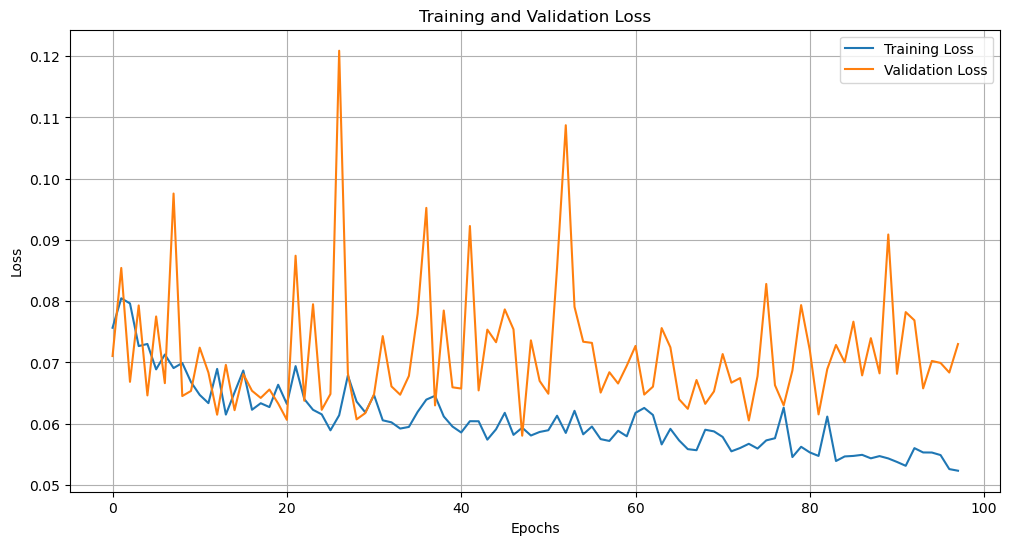

In [127]:
# Checking if there is a overfitting

history_dict = history_others.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [128]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_others.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_others = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_others

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step


,test,pred,diff_val_by_million,diff_percentage
0,1333877.0,9.815573e+05,0.352320,26.413207
1,1056228.0,1.084224e+06,0.027996,2.650576
2,1042283.0,1.044460e+06,0.002177,0.208904
3,1103555.0,1.055593e+06,0.047962,4.346113
4,1096540.0,1.044948e+06,0.051592,4.704970
...,...,...,...,...
129,810533.0,8.071581e+05,0.003375,0.416377
130,830240.0,8.001624e+05,0.030078,3.622763
131,813926.0,7.992300e+05,0.014696,1.805570
132,884362.0,8.148070e+05,0.069555,7.864992


count    134.000000
mean       7.509614
std        7.666163
min        0.055277
25%        1.793997
50%        5.129834
75%       10.031589
max       42.666524
Name: diff_percentage, dtype: float64


<Axes: >

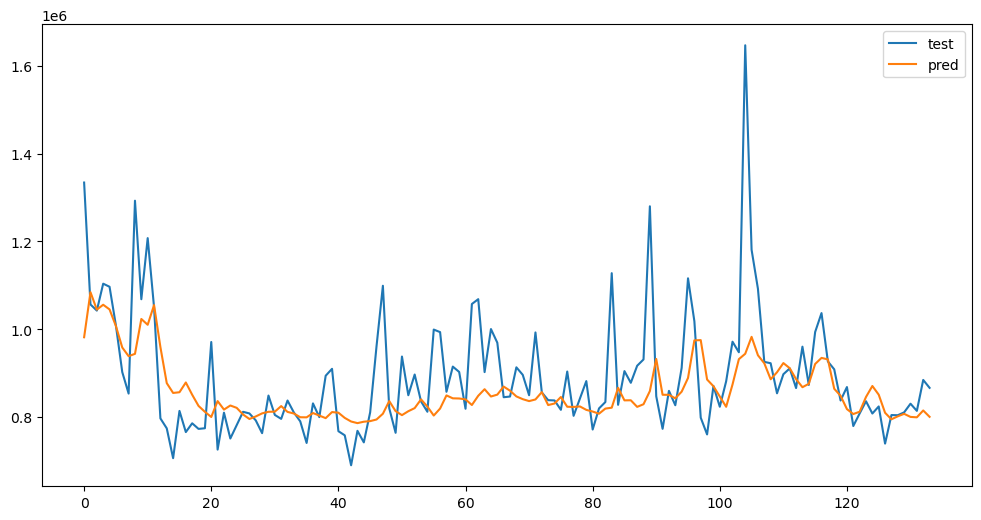

In [129]:
print(data_others["diff_percentage"].describe())

data_others[["test","pred"]].plot(figsize=(12, 6))

In [134]:
# Saving the model

model_others.save('../Saved Models/m_others.keras')

# LSTM of offers : 
<h1 style="color:red;">3</h1>

In [137]:
# Defining the grouped_df to be used here which is the subscription_3 dataframe
grouped_df = subscriptions_3_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [139]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_3.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [141]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [143]:
# Defining the LSTM model
model_3= Sequential()
model_3.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_3.add(LSTM(500, return_sequences=True))  
model_3.add(Dropout(0.1))  
model_3.add(LSTM(300, return_sequences=True)) 
model_3.add(Dropout(0.1)) 
model_3.add(LSTM(300, return_sequences=True)) 
model_3.add(Dropout(0.2))  
model_3.add(LSTM(300, return_sequences=True)) 
model_3.add(Dropout(0.15))
model_3.add(LSTM(350, return_sequences=False)) 
model_3.add(Dense(1))
model_3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 1, 500)              │       1,124,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 1, 500)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_22 (LSTM)                       │ (None, 1, 300)              │         961,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_24 (LSTM)                       │ (None, 1, 300)              │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 1, 300)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 350)                 │         911,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,439,351 (16.93 MB)

 Trainable params: 4,439,351 (16.93 MB)

 Non-trainable params: 0 (0.00 B)

In [145]:
# Compile the model
model_3.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_absolute_error')

# Fit the model
history_3 = model_3.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=8, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - loss: 0.2811 - val_loss: 0.0618
Epoch 2/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0829 - val_loss: 0.0523
Epoch 3/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0631 - val_loss: 0.0556
Epoch 4/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0599 - val_loss: 0.0650
Epoch 5/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0587 - val_loss: 0.0542
Epoch 6/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0582 - val_loss: 0.0332
Epoch 7/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0604 - val_loss: 0.0520
Epoch 8/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0533 - val_loss: 0.0395
Epoch 9/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0525 - val_loss: 0.0451
Epoch 10/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.0586 - val_loss: 0.0585
Epoch 11/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0511 - val_loss: 0.0337
Epoch 12/400
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/ste

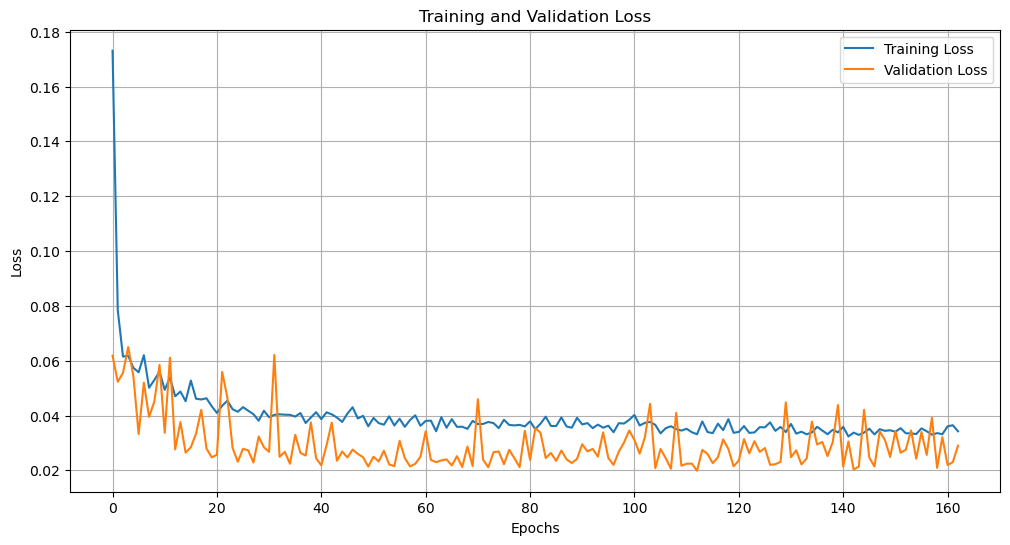

In [146]:
# Checking if there is a overfitting

history_dict = history_3.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [147]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_3.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_3 = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_3

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step


,test,pred,diff_val_by_million,diff_percentage
0,21394223.0,21040846.0,0.353377,1.651740
1,21137938.0,20855222.0,0.282716,1.337481
2,21062921.0,20826014.0,0.236907,1.124759
3,20944361.0,20599008.0,0.345353,1.648907
4,19755915.0,20300532.0,0.544617,2.756729
...,...,...,...,...
135,15016794.0,14934451.0,0.082343,0.548339
136,15079800.0,14714941.0,0.364859,2.419521
137,15186554.0,14567277.0,0.619277,4.077798
138,16245678.0,14984989.0,1.260689,7.760150


count    140.000000
mean       2.829935
std        2.927780
min        0.005864
25%        0.831187
50%        2.032351
75%        3.452277
max       20.411129
Name: diff_percentage, dtype: float64


<Axes: >

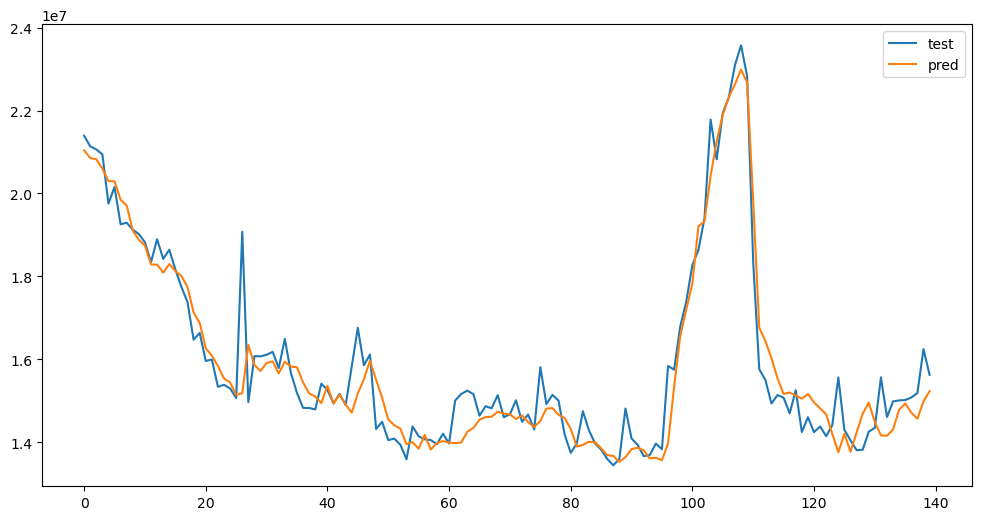

In [148]:
print(data_3["diff_percentage"].describe())

data_3[["test","pred"]].plot(figsize=(12, 6))

In [153]:
# Saving the model

model_3.save('../Saved Models/m_3.keras')

# LSTM of offers : 
<h1 style="color:red;">6</h1>

In [54]:
# Defining the grouped_df to be used here which is the subscription_6 dataframe
grouped_df = subscriptions_6_df

# Adding the lag
for i in range(1, 31):
    grouped_df[f'REVENUE_LAG_{i}'] = grouped_df['REVENUE'].shift(i)
    grouped_df[f'IS_CODE6_ENABLED_{i}'] = grouped_df['IS_CODE6_ENABLED'].shift(i).astype(float)
grouped_df.dropna(inplace=True); grouped_df.reset_index(drop=True,inplace=True)

# Splitting the new lagged dataFrame for training and testing
group_split_value = int(len(grouped_df)*0.8)

df_train = grouped_df.iloc[:group_split_value]
df_test = grouped_df.iloc[group_split_value:]

X_train = df_train.drop(columns=["REPORT_DATE","REVENUE"]).values
y_train = df_train["REVENUE"].values.reshape(-1, 1)

X_test = df_test.drop(columns=["REPORT_DATE","REVENUE"]).values
y_test = df_test["REVENUE"].values.reshape(-1, 1)

In [158]:
# Initialize the scaler for X
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Initialize the scaler for y which is not necessary
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Saving the scalers
scalers = {'scaler_X': scaler_X, 'scaler_y': scaler_y}

with open('../Scalers/scaler_6.pickle', 'wb') as f:
    pickle.dump(scalers, f)

In [160]:
# Reshaping the data to work with the tensors (3D)
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], 1, 61))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], 1, 61))

In [162]:
# Defining the LSTM model
model_6 = Sequential()
model_6.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(68, return_sequences=True))  
model_6.add(Dropout(0.1))  
model_6.add(LSTM(16, return_sequences=False)) 
model_6.add(Dense(1))
model_6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                       │ (None, 1, 68)               │          35,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 1, 68)               │          37,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 1, 68)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 16)                  │           5,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,609 (596.13 KB)

 Trainable params: 152,609 (596.13 KB)

 Non-trainable params: 0 (0.00 B)

In [172]:
# Compile the model
model_6.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Fit the model
history_6 = model_6.fit(X_train_reshaped, y_train_scaled, epochs=400, batch_size=4, validation_data=(X_test_reshaped, y_test_scaled),callbacks=[early_stopping], verbose=1)

Epoch 1/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 0.0149 - val_loss: 0.0153
Epoch 2/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0143 - val_loss: 0.0133
Epoch 3/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0146 - val_loss: 0.0200
Epoch 4/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0159 - val_loss: 0.0140
Epoch 5/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0146 - val_loss: 0.0161
Epoch 6/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0168 - val_loss: 0.0217
Epoch 7/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0144 - val_loss: 0.0152
Epoch 8/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0125 - val_loss: 0.0147
Epoch 9/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0146 - val_loss: 0.0162
Epoch 10/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0157 - val_loss: 0.0120
Epoch 11/400
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0145 - val_loss: 0.0241
Epoch 12/400
140/140 ━━━━━━━━━━━━━━━━━━

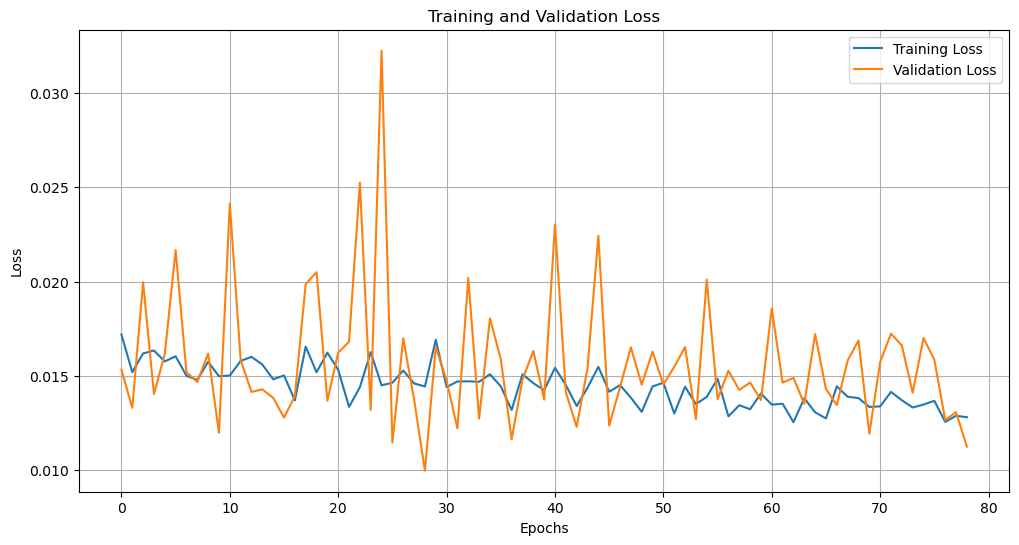

In [173]:
# Checking if there is a overfitting

history_dict = history_6.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [174]:
# Making the dataframe of predictions

y_pred = scaler_y.inverse_transform(model_6.predict(X_test_reshaped))
abs_diff = np.abs((y_pred.reshape(-1) - y_test.reshape(-1)))

data_6 = pd.DataFrame({
    "test":y_test.reshape(-1),
    "pred":y_pred.reshape(-1),
    "diff_val_by_million":abs_diff/1e6,
    "diff_percentage": abs_diff / y_test.reshape(-1) * 100
})

data_6

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step


,test,pred,diff_val_by_million,diff_percentage
0,19997313.0,18666862.0,1.330451,6.653149
1,23733488.0,22005820.0,1.727668,7.279453
2,26238583.0,26275514.0,0.036931,0.140751
3,28187865.0,27994484.0,0.193381,0.686043
4,27356556.0,29105622.0,1.749066,6.393590
...,...,...,...,...
135,9418133.0,8356919.0,1.061214,11.267775
136,9996085.0,8131351.0,1.864734,18.654643
137,10411340.0,8705376.0,1.705964,16.385633
138,12305902.0,11221222.0,1.084680,8.814307


count    140.000000
mean       8.073710
std       12.849396
min        0.055770
25%        2.274180
50%        5.247605
75%        9.919985
max      129.994281
Name: diff_percentage, dtype: float64


<Axes: >

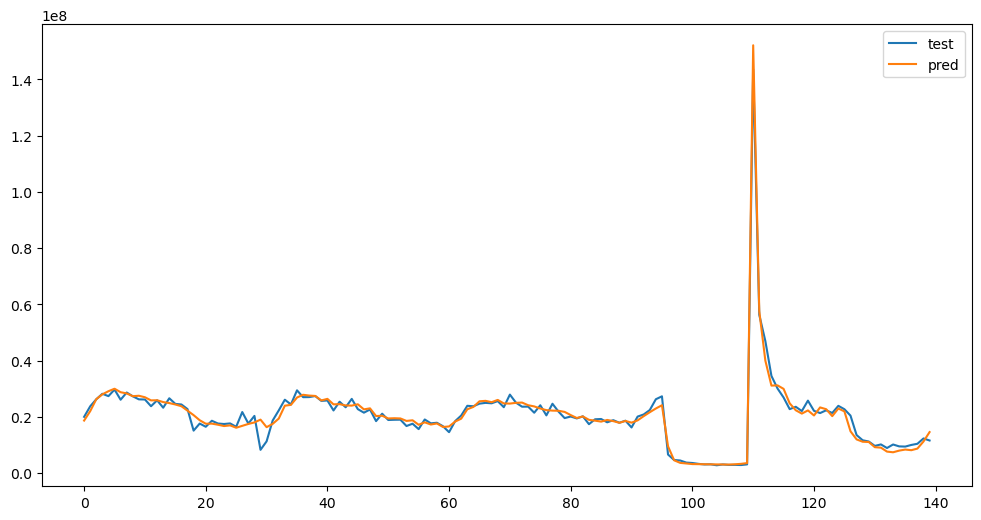

In [175]:
print(data_6["diff_percentage"].describe())

data_6[["test","pred"]].plot(figsize=(12, 6))

In [190]:
# Saving the model

model_6.save('../Saved Models/m_6.keras')

# Fusing all the models into one

<Axes: >

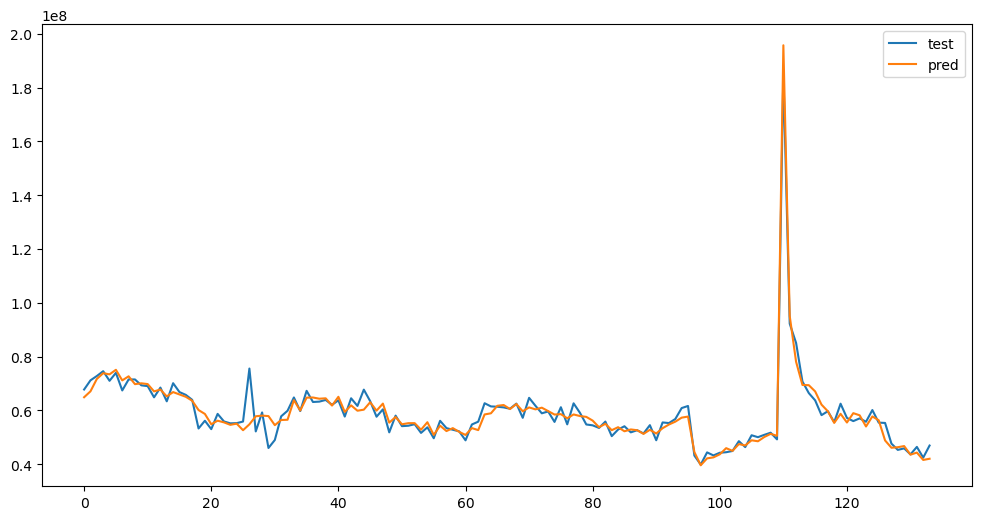

In [195]:
sum_df = pd.DataFrame({
    'test': data_1_2["test"] + data_others["test"] + data_empty["test"] + data_3["test"] + data_6["test"],
    'pred': data_1_2["pred"] + data_others["pred"] + data_empty["pred"] + data_3["pred"] + data_6["pred"]
})

sum_df.plot(figsize=(12, 6))


In [255]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(sum_df.dropna().test,sum_df.dropna().pred)/sum_df["test"].mean() *100

3.574175777137584